<a href="https://colab.research.google.com/github/wph12/css-exercises/blob/main/cartpole_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you wish to run the code, please run it on colab to minimise problems with the runtime environment

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
#dummy video device to avoid pygame errors
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))
pygame.display.init()

# Introduction #

In this notebook, I will explore 3 approaches to the cartpole problem. 
1. Angular-velocity based agent
2. Angular-velocity based agent with correction
3. Deep Q-Learning agent

In [ ]:
#create the environment
env = gym.make("CartPole-v1")

# 1. Angular Velocity - based agent #

### 1. Task 1 ###

Let us first try an intuition from physics: an agent that is based on angular velocity. If angular velocity is negative, it means pole is falling to the left, so we will move to the left as well to "balance" it. Otherwise, we will move to the right. 

In [ ]:
def angular_velocity_agent(observation):
  if (observation[3] < 0): #if pole is moving left/anti-clockwise, go left
    return 0 
  else:       #if pole is moving right/clockwise, go right
    return 1

Sampling a random state from the environment: 

In [ ]:
observation = env.reset()
action = angular_velocity_agent(observation)
print("Observation: ", observation)
print("Chosen Action: ", action)

Observation:  [-0.01241063 -0.03359045 -0.00168369  0.01768388]
Chosen Action:  1


As seen, the action corresponds to angular velocity value (the last value in the observation array). If value is negative, action will be 0 (go left). If value is positive, action will be 1 (go right).

### 1. Task 2 ###

Generate 100 episodes of the environment with our angular velocity agent and plot it in a graph.

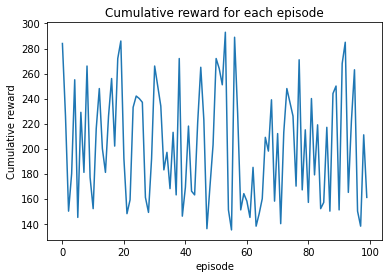

Average cumulative reward: 203.25
Is my agent good enough? True


In [ ]:
def generate_episode():
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(angular_velocity_agent(observation))
      cumulative_reward += reward
  return cumulative_reward

# generates 100 episodes and saves episode results to array
episode_results = []
for i in range(100):
  episode_results.append(generate_episode())

episode_results = np.array(episode_results)

# plots episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

The result seems good enough. The range of values is from around 80 to around 300 average is above 195 most of the time, but occasionally it will drop slightly below. This performance can perhaps still be improved.

### 1. Task 3 ###

**Task 3:** Render video of one episode of the angular velocity agent:

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = angular_velocity_agent(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()


# 2. Angular Velocity - based agent with correction #

### 2. Task 1 ###

A way to improve the agent would be to take the angle of the pole into account (Xu, 2021). If the angle of the pole is too far left, we can try to "correct" it by moving right, regardless of which way the pole is moving at the moment. This allows for greater stabilisation of the pole according to the context and hopefully will show a better result. 

But how much should the threshold angle be? We will first try it out with a value of 6 degrees, or 0.10472 radian.

In [ ]:
def angular_velocity_correction_agent(observation):
  if (observation[2] < -0.10472): #if pole too far left, go left
    return 0
  elif (observation[2] > 0.10472): #if pole is too far right, go right
    return 1
  else:
    if (observation[3] < 0): #if pole is moving left/anti-clockwise, go left
      return 0 
    else: #if pole is moving right/clockwise, go right
      return 1

Taking the value of 100 episodes:

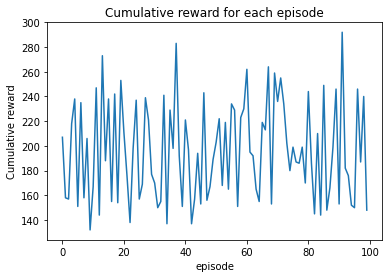

Average cumulative reward: 195.96
Is my agent good enough? True


In [ ]:
def generate_episode():
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(angular_velocity_correction_agent(observation))
      cumulative_reward += reward
  return cumulative_reward
# generates 100 episodes and saves episode results to array

episode_results = []
for i in range(100):
  episode_results.append(generate_episode())

episode_results = np.array(episode_results)

# plots episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = angular_velocity_correction_agent(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

A threshold angle of 6 degrees seems to improve the performance slightly. To find out the best value for angle threshold, we can check the average reward of 100 runs of variable threshold values from 0 to the maximum 12 degrees (0 to 0.20944 rad), at an interval of 0.005 rad.

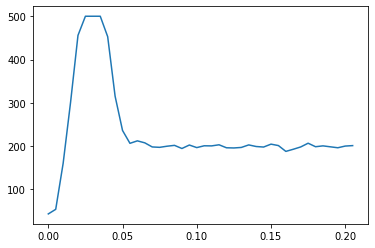

Best value of threshold is: 0.025 , with a reward of 500.0


In [ ]:
def angular_velocity_correction_agent_thres(observation, thres): #redefine with variable thresold variable
  if (observation[2] < -thres): #if pole too far left, go left
    return 0
  elif (observation[2] > thres): #if pole is too far right, go right
    return 1
  else:
    if (observation[3] < 0): 
      return 0
    else:
      return 1

def generate_episode(thres):  #generates episodes of a certain threshold angle value
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(angular_velocity_correction_agent_thres(observation,thres))
      cumulative_reward += reward
  return cumulative_reward

def get_episodes_average(thres): #generates average reward of 100 episodes of a certain threshold angle value
  episode_results = []
  for i in range(100):
    episode_results.append(generate_episode(thres))
  episode_results = np.array(episode_results)
  return episode_results.mean()

x = np.arange(0,0.20944,0.005) #range: 0 deg to 12 deg 
y = np.array([get_episodes_average(i) for i in x])
plt.plot(x,y)
plt.show()
bestValue = x[np.argmax(y)]
print("Best value of threshold is:" , bestValue, ", with a reward of", np.amax(y))

Using this best threshold value, we can verify the correctness of the agent by checking one action when given a random state.

In [ ]:
observation = env.reset()
action = angular_velocity_correction_agent_thres(observation, bestValue)
print("Observation: ", observation)
print("Chosen Action: ", action)

Observation:  [-0.01829965 -0.03959827 -0.0352337  -0.00555469]
Chosen Action:  0


It seems to behave correctly. 

### 2. Task 2 ###

We can plot the graph of 100 episodes using the best threshold value for our angular velocity correction agent.

Threshold angle value is: 0.025


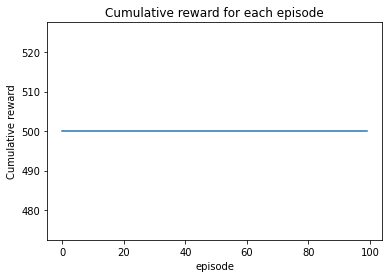

Average cumulative reward: 500.0
Is my agent good enough? True


In [ ]:
print("Threshold angle value is:" , bestValue)

def generate_episode():
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(angular_velocity_correction_agent_thres(observation, bestValue))
      cumulative_reward += reward
  return cumulative_reward

# generates 100 episodes and saves episode results to array
episode_results = []
for i in range(100):
  episode_results.append(generate_episode())

episode_results = np.array(episode_results)

# plots episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

This agent can consistently reach a reward of 500, the maximum score.

### 2. Task 3 ###

Showing 1 episode:

In [ ]:
print("Threshold angle value is:" , bestValue)
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    observation, reward, done, info = env.step(angular_velocity_correction_agent_thres(observation, bestValue))
    if done: 
      break;    
env.close()
show_video()

Threshold angle value is: 0.025


# 3. Deep Q Network Agent

### Setting up and training the model ###

We can also train a Deep Q Network as an agent to solve the cartpole problem. Please note that the code in this section is largely the work of Kurban(2019), with a few minor edits by myself. 

First, we must import libraries and dependencies for the problem.

In [ ]:
import copy
import torch
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output
import torchvision.transforms as T

import time

Next, we have a few hyperparameters. 

*  **n_state** refers to the number of features that define the state of the cart and pole. There are 4, as listed in the problem statement
*  **n_action** is the number of actions we can take: to go left or right.
*   **n_episodes** is the number of episodes we will train the DQN for. It is set at 5000 in order to achieve a good score.
*   **n_hidden** is the number of nodes in the hidden layers of the neural network.
*   Finally, learning rate (**lr**) is set to 0.001, which is the recommended value for most optimizers in Keras. It controls the rate of gradient descent by the optimizers, and by how much network weights and biases are updated. A small learning rate will lead to a slower convergence to the minima, while a larger learning rate might lead to inaccuracy and divergent behaviours. 



In [ ]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 10000
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

Next, the class for our Deep Q Network is defined. The network class consists of 3 attributes:
*   The *loss function*, which is mean squared error
*   The *model itself*, which is a sequential model that is made out of linear layers, meaning a linear transformation is used to transform values.  **state_dim**, **hidden_dim** and **action_dim** will take on the values of our hyperparameters **n_state**, **n_action** and **n_hidden** respectively. Thus, we have 4 layers of neurons in our network: 4 for state input, 50 hidden, then 250 hidden, and finally 2 for output. In between these neuron layers are Leaky ReLU layers, which is a reLU function that has a small coefficient for negative values, instead of setting them to 0. 
*   The *optimizer*, which is Adam, a well-rounded and popular optimizer for stochastic gradient descent. 

The update and predict functions are also defined for this network. 

In Deep Q learning, a neural network is used in lieu of a Q-table. Our network will take the state of the cart and pole as inputs, and then output the Q-values for the actions.

In [ ]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

The Deep Q network class is improved with the addition of a target network, as well as replay memory to give *DoubleDQN*.

The addition of a *target network* would mean that the learning process uses 2 neural networks. The target network is a copy of the main network, but its weights and biases are only updated once every certain number of episodes, unlike the main network which is updated after each step. The results of both main and target networks are used to calculate the loss function and update the weights, which helps to stablilise the training process.
**target_update** is used to update the target network using the main network's state, while **target_predict** uses the target network to predict the q-values of the actions when given a state.

On the other hand, *replay memory* will store past experiences in batches, and train the network periodically on these batches, rather than immediately after each step. This helps to save time, prevent past experiences from being discarded, and also makes learning more stable.

The **replay** function itself will sample past actions and results from the agent's memory and extract information from these datapoints. The temporal difference or new q-value is then calculated with the target model, and then the main model is updated with the data by callning **update()**.


In [ ]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=0.9):
      """New replay function"""
      #Try to improve replay speed
      if len(memory)>=size:
          batch = random.sample(memory,size)
          batch_t = list(map(list, zip(*batch))) #Transpose batch list
          states = batch_t[0]
          actions = batch_t[1]
          next_states = batch_t[2]
          rewards = batch_t[3]
          is_dones = batch_t[4]
      
          states = torch.Tensor(states)
          actions_tensor = torch.Tensor(actions)
          next_states = torch.Tensor(next_states)
          rewards = torch.Tensor(rewards)
          is_dones_tensor = torch.Tensor(is_dones)
      
          is_dones_indices = torch.where(is_dones_tensor==True)[0]
      
          all_q_values = self.model(states) # predicted q_values of all states
          all_q_values_next = self.model(next_states)
          #Update q values
          all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
          all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
      
          
          self.update(states.tolist(), all_q_values.tolist())

Next, we define the Q-learning training algorithm. In the function definition, there are a few interesting parameters that we can discuss: 
*   **gamma**: The discount factor, which makes future rewards worth less than initial rewards
*   **epsilon, eps_decay**: The epsilon and epsilon decay values. This q-learning algorithm uses an epsilon-greedy search, which uses **epsilon** to balance exploration (using random actions regardless of model output) and  
exploitation (using model output for "best" action). At the start, since the model is not trained that well, **epsilon** is initialized to a relatively higher value. However, after each episode, the value of **epsilon** is reduced by multiplying it with **eps_decay**.
*    **replay, replay_size**: **replay** controls if the memory replay feature will be used, which it will be, **replay_size** will control the threshold at which sampling of the replay takes place. Since sampling will occur without replacement, it will thus also control the size of the memory array.
*    **double, n_update**: **double** controls if a target network will be added to create DoubleDQN. If it is enabled, **n_update** will be the number of steps the main network will take before the target network is updated.

An overview of the process in psuedocode is given as follows:


```
initialize replay memory
for each episode:
  update target network once every few episodes
  reset environment
  if game is not finished:
    for each step:
      if a randomly generated value between 0 and 1 is less than epsilon (epsilon greedy search):
        do exploration: do a random action
      else:
        do exploitation with main model
      carry out action
      update total reward and put the action in memory
      update network weights with replay memory
      move environment forward a step
    
  decay epsilon as the training goes on, since exploration is less needed
```



In [ ]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        #plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

In [ ]:
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)

episode: 1, total reward: 20.0
Average replay time: 0.00010395050048828125
episode: 2, total reward: 19.0
Average replay time: 0.03742039203643799
episode: 3, total reward: 25.0
Average replay time: 0.05097460746765137


<ipython-input-20-fa85a8ffea61>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states = torch.Tensor(states)
<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 4, total reward: 21.0
Average replay time: 0.054049670696258545
episode: 5, total reward: 17.0
Average replay time: 0.05211477279663086
episode: 6, total reward: 9.0
Average replay time: 0.04703648885091146
episode: 7, total reward: 8.0
Average replay time: 0.042881897517613


<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 8, total reward: 10.0
Average replay time: 0.04128307104110718
episode: 9, total reward: 10.0
Average replay time: 0.03990345531039768
episode: 10, total reward: 9.0
Average replay time: 0.038217926025390626
episode: 11, total reward: 18.0
Average replay time: 0.03890217434276234
episode: 12, total reward: 11.0
Average replay time: 0.037986179192860924
episode: 13, total reward: 13.0
Average replay time: 0.03752708435058594
episode: 14, total reward: 18.0
Average replay time: 0.03812197276524135
episode: 15, total reward: 15.0
Average replay time: 0.03831350008646647
episode: 16, total reward: 12.0
Average replay time: 0.03794050216674805
episode: 17, total reward: 16.0
Average replay time: 0.03879349371966194
episode: 18, total reward: 14.0
Average replay time: 0.038708355691697865
episode: 19, total reward: 19.0
Average replay time: 0.03940987586975098
episode: 20, total reward: 27.0
Average replay time: 0.04132912158966064
episode: 21, total reward: 12.0
Average replay time

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 27, total reward: 51.0
Average replay time: 0.06157374382019043
episode: 28, total reward: 63.0
Average replay time: 0.06604201453072685
episode: 29, total reward: 64.0
Average replay time: 0.07030048863641147
episode: 30, total reward: 55.0
Average replay time: 0.07268437544504801
episode: 31, total reward: 79.0
Average replay time: 0.07477375768846081
episode: 32, total reward: 101.0
Average replay time: 0.07846628874540329
episode: 33, total reward: 127.0
Average replay time: 0.08262887145533707
episode: 34, total reward: 171.0
Average replay time: 0.0892569948645199
episode: 35, total reward: 192.0
Average replay time: 0.09609067099434988
episode: 36, total reward: 209.0
Average replay time: 0.10337778594758776
episode: 37, total reward: 213.0
Average replay time: 0.11070150298041266
episode: 38, total reward: 167.0
Average replay time: 0.11539600397411146
episode: 39, total reward: 178.0
Average replay time: 0.12042074325757149
episode: 40, total reward: 207.0
Average rep

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 64, total reward: 278.0
Average replay time: 0.2528145834803581
episode: 65, total reward: 186.0
Average replay time: 0.25400599699753984
episode: 66, total reward: 154.0
Average replay time: 0.2542951323769309
episode: 67, total reward: 319.0
Average replay time: 0.258818060604494
episode: 68, total reward: 171.0
Average replay time: 0.25949256209766164
episode: 69, total reward: 162.0
Average replay time: 0.2598316358483356
episode: 70, total reward: 148.0
Average replay time: 0.2599877153124128
episode: 71, total reward: 159.0
Average replay time: 0.26023599127648583
episode: 72, total reward: 104.0
Average replay time: 0.25910062922371757
episode: 73, total reward: 182.0
Average replay time: 0.2601003679510665
episode: 74, total reward: 180.0
Average replay time: 0.2609342948810474
episode: 75, total reward: 186.0
Average replay time: 0.2617771911621094
episode: 76, total reward: 161.0
Average replay time: 0.2622319961849012
episode: 77, total reward: 162.0
Average replay 

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 125, total reward: 151.0
Average replay time: 0.3156442184448242
episode: 126, total reward: 159.0
Average replay time: 0.31542272794814336
episode: 127, total reward: 170.0
Average replay time: 0.3155303977605865
episode: 128, total reward: 242.0
Average replay time: 0.31646756269037724
episode: 129, total reward: 170.0
Average replay time: 0.3163052677184112
episode: 130, total reward: 156.0
Average replay time: 0.3159952585513775
episode: 131, total reward: 137.0
Average replay time: 0.3155020721086109
episode: 132, total reward: 174.0
Average replay time: 0.31540686614585645
episode: 133, total reward: 163.0
Average replay time: 0.3151728031330539
episode: 134, total reward: 136.0
Average replay time: 0.3146817541834134
episode: 135, total reward: 135.0
Average replay time: 0.3140523769237377
episode: 136, total reward: 178.0
Average replay time: 0.31402886264464436
episode: 137, total reward: 130.0
Average replay time: 0.31346728331851265
episode: 138, total reward: 139.0

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 216, total reward: 140.0
Average replay time: 0.32405343651771545
episode: 217, total reward: 164.0
Average replay time: 0.3239017796406548
episode: 218, total reward: 269.0
Average replay time: 0.32462717086896986
episode: 219, total reward: 128.0
Average replay time: 0.32422471046447754
episode: 220, total reward: 207.0
Average replay time: 0.3252522847869179
episode: 221, total reward: 162.0
Average replay time: 0.32569167732653037
episode: 222, total reward: 226.0
Average replay time: 0.3269616859453218
episode: 223, total reward: 303.0
Average replay time: 0.3293448424660037
episode: 224, total reward: 194.0
Average replay time: 0.33045109787157606
episode: 225, total reward: 224.0
Average replay time: 0.3319843419392904
episode: 226, total reward: 110.0
Average replay time: 0.33195338839978245
episode: 227, total reward: 161.0
Average replay time: 0.33221582274079847
episode: 228, total reward: 132.0
Average replay time: 0.3318336888363487
episode: 229, total reward: 145

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 343, total reward: 131.0
Average replay time: 0.33571548503619936
episode: 344, total reward: 150.0
Average replay time: 0.33549561750057133
episode: 345, total reward: 129.0
Average replay time: 0.33518672196761423
episode: 346, total reward: 303.0
Average replay time: 0.33577558002030916
episode: 347, total reward: 170.0
Average replay time: 0.33565797723335905
episode: 348, total reward: 108.0
Average replay time: 0.3352622931030975
episode: 349, total reward: 45.0
Average replay time: 0.3345166728284776
episode: 350, total reward: 138.0
Average replay time: 0.33425107274736676
episode: 351, total reward: 273.0
Average replay time: 0.33467335103244183
episode: 352, total reward: 118.0
Average replay time: 0.334315876391801
episode: 353, total reward: 114.0
Average replay time: 0.33393355942312786
episode: 354, total reward: 148.0
Average replay time: 0.3337255285284613
episode: 355, total reward: 194.0
Average replay time: 0.33377552032470703
episode: 356, total reward: 259

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 512, total reward: 100.0
Average replay time: 0.3602323504164815
episode: 513, total reward: 106.0
Average replay time: 0.35994010083159506
episode: 514, total reward: 107.0
Average replay time: 0.35960462353108924
episode: 515, total reward: 105.0
Average replay time: 0.35927726690051626
episode: 516, total reward: 134.0
Average replay time: 0.35927315414413924
episode: 517, total reward: 342.0
Average replay time: 0.360263089838526
episode: 518, total reward: 500.0
Average replay time: 0.36213806605246995
episode: 519, total reward: 112.0
Average replay time: 0.3620740953897465
episode: 520, total reward: 190.0
Average replay time: 0.362400117287269
episode: 521, total reward: 252.0
Average replay time: 0.3630447442609381
episode: 522, total reward: 131.0
Average replay time: 0.3630266230681847
episode: 523, total reward: 143.0
Average replay time: 0.36283585400699886
episode: 524, total reward: 148.0
Average replay time: 0.36262793167856816
episode: 525, total reward: 113.0

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 729, total reward: 117.0
Average replay time: 0.36070857715214233
episode: 730, total reward: 180.0
Average replay time: 0.3609197966039997
episode: 731, total reward: 117.0
Average replay time: 0.36088966377456605
episode: 732, total reward: 325.0
Average replay time: 0.3614387701117927
episode: 733, total reward: 174.0
Average replay time: 0.361368776180897
episode: 734, total reward: 203.0
Average replay time: 0.36137795773124176
episode: 735, total reward: 209.0
Average replay time: 0.361392271275423
episode: 736, total reward: 170.0
Average replay time: 0.3613107680626538
episode: 737, total reward: 21.0
Average replay time: 0.3608672363301954
episode: 738, total reward: 23.0
Average replay time: 0.36043031784254037
episode: 739, total reward: 27.0
Average replay time: 0.3600016030632917
episode: 740, total reward: 22.0
Average replay time: 0.35957193020227796
episode: 741, total reward: 500.0
Average replay time: 0.3602770040875022
episode: 742, total reward: 249.0
Avera

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 1000, total reward: 63.0
Average replay time: 0.3760785517692566
episode: 1001, total reward: 23.0
Average replay time: 0.3757666476837524
episode: 1002, total reward: 125.0
Average replay time: 0.37574601149606607
episode: 1003, total reward: 426.0
Average replay time: 0.3765503095605913
episode: 1004, total reward: 163.0
Average replay time: 0.37655123866411794
episode: 1005, total reward: 124.0
Average replay time: 0.37640748545898134
episode: 1006, total reward: 172.0
Average replay time: 0.3763318647210214
episode: 1007, total reward: 185.0
Average replay time: 0.37627918788906123
episode: 1008, total reward: 59.0
Average replay time: 0.37601129497800556
episode: 1009, total reward: 63.0
Average replay time: 0.37575091786379855
episode: 1010, total reward: 59.0
Average replay time: 0.37548270957304697
episode: 1011, total reward: 82.0
Average replay time: 0.37525689849513927
episode: 1012, total reward: 27.0
Average replay time: 0.3749311747758285
episode: 1013, total rew

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 2000, total reward: 117.0
Average replay time: 0.3860371067523956
episode: 2001, total reward: 179.0
Average replay time: 0.3860134388553328
episode: 2002, total reward: 213.0
Average replay time: 0.3860104704474831
episode: 2003, total reward: 364.0
Average replay time: 0.3861438999518834
episode: 2004, total reward: 500.0
Average replay time: 0.38639489595523613
episode: 2005, total reward: 379.0
Average replay time: 0.386537965693676
episode: 2006, total reward: 217.0
Average replay time: 0.38652707156488453
episode: 2007, total reward: 60.0
Average replay time: 0.3863872987569477
episode: 2008, total reward: 120.0
Average replay time: 0.3863028946863228
episode: 2009, total reward: 170.0
Average replay time: 0.38626136490217544
episode: 2010, total reward: 418.0
Average replay time: 0.38643197206715446
episode: 2011, total reward: 500.0
Average replay time: 0.38667167294149907
episode: 2012, total reward: 212.0
Average replay time: 0.3866581049401528
episode: 2013, total r

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 3000, total reward: 500.0
Average replay time: 0.3945318188667297
episode: 3001, total reward: 237.0
Average replay time: 0.39461385262326293
episode: 3002, total reward: 129.0
Average replay time: 0.39460090007248283
episode: 3003, total reward: 148.0
Average replay time: 0.3946104313268925
episode: 3004, total reward: 500.0
Average replay time: 0.39496836228948456
episode: 3005, total reward: 307.0
Average replay time: 0.3951742088933554
episode: 3006, total reward: 162.0
Average replay time: 0.39522983158578573
episode: 3007, total reward: 182.0
Average replay time: 0.39521864168581317
episode: 3008, total reward: 116.0
Average replay time: 0.3951626836936525
episode: 3009, total reward: 185.0
Average replay time: 0.395150418058112
episode: 3010, total reward: 129.0
Average replay time: 0.395099790230938
episode: 3011, total reward: 350.0
Average replay time: 0.3951890415545121
episode: 3012, total reward: 169.0
Average replay time: 0.3951656017328797
episode: 3013, total r

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 4000, total reward: 23.0
Average replay time: 0.4292975307703018
episode: 4001, total reward: 39.0
Average replay time: 0.429214449353112
episode: 4002, total reward: 97.0
Average replay time: 0.42915485049414076
episode: 4003, total reward: 10.0
Average replay time: 0.42905187910567394
episode: 4004, total reward: 10.0
Average replay time: 0.428949129926813
episode: 4005, total reward: 9.0
Average replay time: 0.42884578913189797
episode: 4006, total reward: 9.0
Average replay time: 0.42874308282354145
episode: 4007, total reward: 9.0
Average replay time: 0.4286398460420552
episode: 4008, total reward: 10.0
Average replay time: 0.42853711149887647
episode: 4009, total reward: 10.0
Average replay time: 0.4284345235394016
episode: 4010, total reward: 10.0
Average replay time: 0.428331957731461
episode: 4011, total reward: 9.0
Average replay time: 0.4282298061325199
episode: 4012, total reward: 10.0
Average replay time: 0.4281286680448804
episode: 4013, total reward: 9.0
Average

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 5007, total reward: 10.0
Average replay time: 0.39075375560374226
episode: 5008, total reward: 9.0
Average replay time: 0.390682845212781
episode: 5009, total reward: 14.0
Average replay time: 0.3906127838204068
episode: 5010, total reward: 49.0
Average replay time: 0.39056702797522325
episode: 5011, total reward: 10.0
Average replay time: 0.39049534021178495
episode: 5012, total reward: 9.0
Average replay time: 0.3904224689351209
episode: 5013, total reward: 49.0
Average replay time: 0.39037575741715946
episode: 5014, total reward: 72.0
Average replay time: 0.3903415196437402
episode: 5015, total reward: 161.0
Average replay time: 0.39033780183535394
episode: 5016, total reward: 48.0
Average replay time: 0.3902806466180932
episode: 5017, total reward: 9.0
Average replay time: 0.39020589330839356
episode: 5018, total reward: 10.0
Average replay time: 0.39013158899704836
episode: 5019, total reward: 11.0
Average replay time: 0.3900575131908264
episode: 5020, total reward: 10.0


<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 6000, total reward: 86.0
Average replay time: 0.3523323697646459
episode: 6001, total reward: 121.0
Average replay time: 0.352319164209377
episode: 6002, total reward: 159.0
Average replay time: 0.3523129701455487
episode: 6003, total reward: 152.0
Average replay time: 0.3523065487424592
episode: 6004, total reward: 399.0
Average replay time: 0.3523773652644732
episode: 6005, total reward: 248.0
Average replay time: 0.3524056053876281
episode: 6006, total reward: 33.0
Average replay time: 0.35235718584362363
episode: 6007, total reward: 188.0
Average replay time: 0.3523605126637636
episode: 6008, total reward: 174.0
Average replay time: 0.352355596466801
episode: 6009, total reward: 33.0
Average replay time: 0.35230670790244584
episode: 6010, total reward: 112.0
Average replay time: 0.35228501810210316
episode: 6011, total reward: 305.0
Average replay time: 0.352324339618026
episode: 6012, total reward: 307.0
Average replay time: 0.3523873365964401
episode: 6013, total reward:

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 7000, total reward: 115.0
Average replay time: 0.3663054896422795
episode: 7001, total reward: 279.0
Average replay time: 0.36636403645298987
episode: 7002, total reward: 401.0
Average replay time: 0.36647649102127916
episode: 7003, total reward: 189.0
Average replay time: 0.36650346960661223
episode: 7004, total reward: 310.0
Average replay time: 0.3665805555016296
episode: 7005, total reward: 138.0
Average replay time: 0.36656900122708547
episode: 7006, total reward: 353.0
Average replay time: 0.366609304556328
episode: 7007, total reward: 120.0
Average replay time: 0.3665890564026362
episode: 7008, total reward: 157.0
Average replay time: 0.3665779656539225
episode: 7009, total reward: 128.0
Average replay time: 0.3665611829987639
episode: 7010, total reward: 164.0
Average replay time: 0.36655251939014427
episode: 7011, total reward: 142.0
Average replay time: 0.36653786044949865
episode: 7012, total reward: 312.0
Average replay time: 0.3665691997688019
episode: 7013, total

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 8000, total reward: 115.0
Average replay time: 0.3766884917914867
episode: 8001, total reward: 182.0
Average replay time: 0.37668555686658894
episode: 8002, total reward: 296.0
Average replay time: 0.37670934152615065
episode: 8003, total reward: 93.0
Average replay time: 0.3766835017098824
episode: 8004, total reward: 216.0
Average replay time: 0.3766881009747183
episode: 8005, total reward: 201.0
Average replay time: 0.3766874545369574
episode: 8006, total reward: 331.0
Average replay time: 0.376718816684539
episode: 8007, total reward: 211.0
Average replay time: 0.37672084054057187
episode: 8008, total reward: 253.0
Average replay time: 0.37673420294538723
episode: 8009, total reward: 170.0
Average replay time: 0.3767271747689135
episode: 8010, total reward: 131.0
Average replay time: 0.3767130361514145
episode: 8011, total reward: 169.0
Average replay time: 0.3767073441944591
episode: 8012, total reward: 278.0
Average replay time: 0.376726066328202
episode: 8013, total rew

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 9000, total reward: 398.0
Average replay time: 0.3839105166594187
episode: 9001, total reward: 127.0
Average replay time: 0.3839143274784247
episode: 9002, total reward: 191.0
Average replay time: 0.3839275268310177
episode: 9003, total reward: 217.0
Average replay time: 0.38393027348398145
episode: 9004, total reward: 131.0
Average replay time: 0.3839167863567476
episode: 9005, total reward: 133.0
Average replay time: 0.38390143869454035
episode: 9006, total reward: 182.0
Average replay time: 0.3838964791502287
episode: 9007, total reward: 202.0
Average replay time: 0.383896813933164
episode: 9008, total reward: 229.0
Average replay time: 0.38390117301398863
episode: 9009, total reward: 500.0
Average replay time: 0.3839650008029792
episode: 9010, total reward: 151.0
Average replay time: 0.38395405826505097
episode: 9011, total reward: 100.0
Average replay time: 0.3839316853354025
episode: 9012, total reward: 147.0
Average replay time: 0.38391922557824887
episode: 9013, total 

<ipython-input-20-fa85a8ffea61>:39: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


episode: 10000, total reward: 173.0
Average replay time: 0.39093847515583036


### 3. Task 1 ###

With our trained model, we can define an agent to find the best action given some observation. As required, we will put it through a random state to check its behaviour.

In [ ]:
def DQN_agent(observation, model):
  q_values = model.predict(observation)
  action = torch.argmax(q_values).item()
  return action

In [ ]:
observation = env.reset()
action = DQN_agent(observation, dqn_double) #model here refers to the trained main model
print("Observation: ", observation)
print("Chosen Action: ", action)

Observation:  [ 0.0166136  -0.02912561 -0.01810897  0.02606838]
Chosen Action:  0


### 3. Task 2 ###

With our agent, we can generate 100 episodes and find the average rewards over the episodes. 

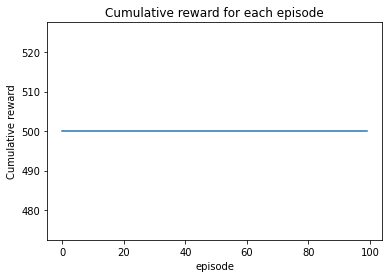

Average cumulative reward: 500.0
Is my agent good enough? True


In [ ]:
def generate_episode():
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done:
      observation, reward, done, info = env.step(DQN_agent(observation, dqn_double)) #model here refers to the trained main model
      cumulative_reward += reward
  return cumulative_reward

# generates 100 episodes and saves episode results to array
episode_results = []
for i in range(100):
  episode_results.append(generate_episode())

episode_results = np.array(episode_results)

# plots episodes
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

### 3. Task 3 ###

Finally, here is a video of our agent in action.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = DQN_agent(observation, dqn_double)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()


# References #

Kansal, S., &amp; Martin, B. (2019). Reinforcement Q-learning from scratch in Python with Openai Gym. Learn Data Science - Tutorials, Books, Courses, and More. Retrieved from https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/ 


Kurban, R. (2019, December 12). Deep Q learning for the Cartpole. Medium. Retrieved from https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f 

Xu, J. (2021, February 21). How to beat the Cartpole game in 5 lines. Medium. Retrieved from https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f 

Wang, M. (2021, October 3). Deep Q-learning tutorial: Mindqn. Medium. Retrieved March 28, 2023, from https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc 
